# Comparison between Gradient Descent and Adam.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from opt_utils import load_dataset

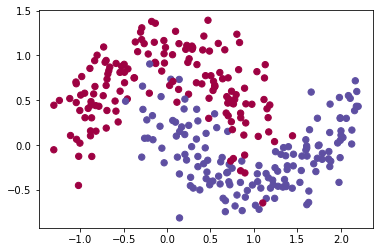

In [2]:
X_train, y_train = load_dataset()

# Model development

In [3]:
'''
Defining number of units in each layers.

Inputs: -
------
units_in_layers - Number of units for each layer in the form of a list. 

Output: -
------
Prints number of units in each layer.
'''

units_in_layers = [X_train.shape[0], 10, 5, 1]
total_layers = len(units_in_layers)

print('Number of units in each layers are:')

for i in range(len(units_in_layers)):
    print(str(i) + f' layer has {units_in_layers[i]} units')

print('---------------------------------------------------')
print(f'Total number of layers are {total_layers}')

Number of units in each layers are:
0 layer has 2 units
1 layer has 10 units
2 layer has 5 units
3 layer has 1 units
---------------------------------------------------
Total number of layers are 4


In [4]:
def initialization_func(units_in_layers, total_layers):
    '''
    This function initializes weights and bias for the layers.
    
    Inputs: -
    ------
    units_in_layers - Number of units for each layer in the form of a list. 
    total_layers - Total number of layers.

    Returns: -
    ------
    weights - Dictionary containing weights and bias.
    '''
    
    np.random.seed(5)
    weights = {}
    
    for i in range(1, total_layers):
        weights['W' + str(i)] = np.random.randn(units_in_layers[i], 
                                                units_in_layers[i - 1])*np.sqrt(2/units_in_layers[i - 1])
        weights['b' + str(i)] = np.zeros((units_in_layers[i], 
                                                    1))
    
    return weights

In [5]:
def forward_activation(A_ref, W, b, activation, keep_prob, position):
    '''
    Implements the forward propagation and calculates the required Activation.
    
    Inputs: -
    ------
    A_ref - Activations from previous layer (Initially it is equal to the input data). 
    W - Weight associated with the corresponding layer.
    b - Bias associated with the corresponding layer.
    activation - Name of the activation function to be implemented.
    keep_prob - Probability of keeping units.
    position - Select 'hidden' or 'last' to calculate the activations
               at hidden layer or last layer.
    
    Returns: -
    ------
    a - Activation value for the next layer.
    forward_cache - List containing values of A_ref, W, b, Z which is used during 
                    backward propagation. 
                    Example: - For initial layer the forward_cache will be
                    forward_cache = (A_ref 0, W1, b1, z1)
                    0 --> refers to the input layer or activation values of the previous layer.
                    1 --> refers to the values associated with the 1st layer.
    d - An array used to dropout.
    '''
    if position != 'last':
        if activation == 'sigmoid':
            z = np.matmul(W, A_ref) + b
            a = 1/(1 + np.exp(-z))
            d = np.random.rand(a.shape[0], a.shape[1]) < keep_prob
            a = a*d
            a = a/keep_prob
            forward_cache = (A_ref, W, b, z)
            return a, forward_cache, d

        elif activation == 'relu':
            z = np.matmul(W, A_ref) + b
            a = np.maximum(0, z)
            d = np.random.rand(a.shape[0], a.shape[1]) < keep_prob
            a = a*d
            a = a/keep_prob
            forward_cache = (A_ref, W, b, z)
            return a, forward_cache, d
        
    else:
        if activation == 'sigmoid':
            z = np.matmul(W, A_ref) + b
            a = 1/(1 + np.exp(-z))
            forward_cache = (A_ref, W, b, z)
            return a, forward_cache

        elif activation == 'relu':
            z = np.matmul(W, A_ref) + b
            a = np.maximum(0, z)
            forward_cache = (A_ref, W, b, z)
            return a, forward_cache
            

In [6]:
def backward_activation_sigmoid(z):
    '''
    Calculates the derivative of sigmoid activation.
    
    Inputs: -
    ------
    z - Forward propagation value. This value is collected from **forward_cache**
        of **forward_activation** function.

    Returns: -
    ------
    Derivative of sigmoid function.
    '''
    
    sig = 1/(1 + np.exp(-z))
        
    return sig*(1 - sig)
    
def backward_activation_relu(z):
    '''
    Calculates the derivative of ReLU activation.
    
    Inputs: -
    ------
    z - Forward propagation value. This value is collected from **forward_cache**
        of **forward_activation** function.

    Returns: -
    ------
    Derivative of ReLU function.
    '''
        
    relu_grad = z.copy()         
    relu_grad[relu_grad <= 0] = 0
    relu_grad[relu_grad > 0] = 1

    return relu_grad 

In [7]:
def forward_prop_func(weights, X_train, keep_prob):
    '''
    Implements the forward propagation and calculates the Activation for every layer.
    
    Inputs: -
    ------
    weights - Initial weights calculated from **initialization_func** function.
    X_train - Input data.
    keep_prob - Probability of keeping units.

    Returns: -
    ------
    A_last - Activation value of the last layer.
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    D - List containing arrays for implementing Dropout.
    '''
    
    L = len(list(weights.keys()))//2
    A_ref = X_train.copy()
    cache = []
    D = []
    D.append(1)       # To make number of weights and D equal for
                      # programming.
        
    for i in range(L - 1):
        A_next, forward_cache, d = forward_activation(A_ref, weights['W' + str(i + 1)],
                                                  weights['b' + str(i + 1)], activation = 'relu',
                                                  keep_prob = keep_prob,
                                                  position = 'hidden')
        A_ref = A_next
        cache.append(forward_cache)
        D.append(d)
    
    A_last, forward_cache = forward_activation(A_ref, weights['W' + str(L)],
                                               weights['b' + str(L)], activation = 'sigmoid',
                                               keep_prob = keep_prob,
                                               position = 'last')
    cache.append(forward_cache)
    
    return A_last, cache, D

In [8]:
def cost_func(A_last, y_train, lambda_, weights):
    '''
    Calculates the cost for a given value of weights.
    
    Inputs: -
    ------
    A_last - Activation value of the last layer calculated 
             from **forward_prop_func** function.
    y_train - Label data.
    lambda_ - Regularization value.
    weights - Dictionary containing weights and bias.

    Returns: -
    ------
    train_cost - Training cost for a given value of weights.
    dA_last - Derivative of Loss with respect to the last activation layer.
    '''
    
    m = y_train.shape[1]
    epsilon = 1e-5
    L = len(list(weights.keys()))//2
    regular_cost = 0
    
    for i in range(1, L):
        regular_cost += np.sum(weights['W' + str(i)]**2)
    
    train_cost = ((-(y_train*np.log(A_last + epsilon)
                   + (1 - y_train)*np.log(1 - A_last + epsilon))).mean()
                   + (lambda_/(2*m))*regular_cost)
                 
    
    dA_last = (-(np.divide(y_train, A_last + epsilon)
               - np.divide((1 - y_train), (1 - A_last + epsilon))))
    
    return train_cost, dA_last

In [9]:
def dZ_func(dA_last, Z, activation):
    '''
    Calculates derivative of Loss with respect to the forward propagation layer.
    
    Inputs: -
    ------
    dA_last - Derivative of Loss with respect to the last activation layer.
              This value is collected from **cost_func** function.
    Z - This value is collected from **forward_cache** of **forward_activation** function.
    activation - Name of the activation function to be implemented.

    Returns: -
    ------
    dZ values.
    '''
    
    if activation == 'relu':
        return dA_last*backward_activation_relu(Z)
    
    elif activation == 'sigmoid':
        return dA_last*backward_activation_sigmoid(Z)

In [10]:
def grad(cache, dA_last, activation, lambda_, dr, keep_prob):
    '''
    Calculates gradients.
    
    Inputs: -
    ------
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    dA_last - Derivative of Loss with respect to the last activation layer.
              This value is collected from **cost_func** function.
    activation - Name of the activation function to be implemented.
    lambda_ - Regularization value.
    dr - An array for implementing Dropout.
    keep_prob - Probability of keeping the units.
    
    Returns: -
    ------
    dA_prev - Derivative of Loss with respect to the previous activation layer.
    dw_ - Weight gradient.
    db_ - Bias gradient.
    '''
    
    A_prev, W, b, Z = cache
    m = A_prev.shape[1]
    
    dz = dZ_func(dA_last, Z, activation)
    dw_ = (1.0/m)*np.matmul(dz, A_prev.T) + (lambda_/m)*W
    db_ = (1.0/m)*(dz).sum(axis = 1, keepdims = True)
    dA_prev = np.matmul(W.T, dz)
    dA_prev = dA_prev*dr
    dA_prev = dA_prev/keep_prob
    
    return dA_prev, dw_, db_     

In [11]:
def back_prop_func(A_last, cache, y_train, lambda_, weights, D, keep_prob):
    '''
    Calculates gradients.
    
    Inputs: -
    ------
    A_last - Activation value of the last layer calculated 
             from **forward_prop_func** function.
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    y_train - Label data.
    lambda_ - Regularization value.
    weights - Dictionary containing weights and bias.
    D - List containing arrays for implementing Dropout.
    keep_prob - Probability of keeping the units.

    Returns: -
    ------
    grads - Dictionary of gradients.
    train_cost - Value of training cost.
    '''
    
    grads = {}
    L = len(cache)
    
    train_cost, dA_last = cost_func(A_last, y_train, lambda_ = lambda_, weights = weights)
    
    current_cache = cache[-1]
    dr = D[-1]
    dA_temp, dw_temp, db_temp = grad(current_cache, dA_last, activation = 'sigmoid',
                                     lambda_ = lambda_, dr = dr, keep_prob = keep_prob)
    grads['dA' + str(L)] = dA_temp
    grads['dW' + str(L)] = dw_temp
    grads['dB' + str(L)] = db_temp
    
    for t in reversed(range(L - 1)):
        current_cache = cache[t]
        dr = D[t]
        grads['dA' + str(t + 1)], grads['dW' + str(t + 1)], grads['dB' + str(t + 1)] = grad(current_cache, grads['dA' + str(t + 2)],
                                                                                            activation = 'relu', lambda_ = lambda_,
                                                                                            dr = dr, keep_prob = keep_prob)

    return grads, train_cost

In [12]:
def mini_batch(X_train, y_train, batch_size, seed):
    '''
    Produces mini batches.
    
    Inputs: -
    ------
    X_train - Input data.
    y_train - Label data.
    batch_size - Sample size of data.
    seed - It is used to shuffle the data. 
    
    Returns: -
    ------
    mini_batches - List of tuples containing X and y data.
    '''
    
    np.random.seed(seed)
    m = X_train.shape[1]
    p = np.random.permutation(m)
    
    X_shuffle =  X_train[:, p]
    y_shuffle =  y_train[:, p]
    
    mini_batches = []
    
    for i in range(len(p)//batch_size):
        X_temp = X_shuffle[:, i*batch_size: (i + 1)*batch_size]
        y_temp = y_shuffle[:, i*batch_size: (i + 1)*batch_size]
        mini_batches.append((X_temp, y_temp))
        
    X_temp = X_shuffle[:, (i + 1)*batch_size: ]
    y_temp = y_shuffle[:, (i + 1)*batch_size: ]
    mini_batches.append((X_temp, y_temp))
    
    return mini_batches

In [13]:
def adam_initializer(weights):
    '''
    Implements Adam initializer.
    
    Inputs: -
    ------
    weights - Dictionary containing weights and bias.
    
    Returns: -
    ------
    v, s as a dictionary.
    '''
    
    L = len(list(weights.keys()))//2
    v = {}
    s = {}
    
    for i in range(L):
        v['dW' + str(i + 1)] = np.zeros(weights['W' + str(i + 1)].shape)
        v['db' + str(i + 1)] = np.zeros(weights['b' + str(i + 1)].shape)
        
        s['dW' + str(i + 1)] = np.zeros(weights['W' + str(i + 1)].shape)
        s['db' + str(i + 1)] = np.zeros(weights['b' + str(i + 1)].shape)
        
    return v, s

In [14]:
def Adam(weights, v, s, grads, beta1, beta2, t, learning_rate):
    '''
    Implements Adam.
    
    Inputs: -
    ------
    weights - Dictionary containing weights and bias.
    v - Moving average.
    s - Moving average.
    grads - Dictionary of gradients. This value is collected from
            **back_prop_func**.
    beta1, beta2 - Parameters.
    t - Used for bias correction.
    learning_rate - Value of learning rate.

    Returns: -
    ------
    Updated values of weights.
    '''
    epsi = 1e-8
    lr = learning_rate
    L = len(list(weights.keys()))//2
    v_corrected = {}
    s_corrected = {}
    
    for i in range(L):
        v['dW' + str(i + 1)] = beta1*v['dW' + str(i + 1)] + (1 - beta1)*grads['dW' + str(i + 1)]
        v['db' + str(i + 1)] = beta1*v['db' + str(i + 1)] + (1 - beta1)*grads['dB' + str(i + 1)]
        
        # Corrected values of v
        v_corrected['dW' + str(i + 1)] = v['dW' + str(i + 1)]/(1 - beta1**t)
        v_corrected['db' + str(i + 1)] = v['db' + str(i + 1)]/(1 - beta1**t)
        
        s['dW' + str(i + 1)] = beta2*s['dW' + str(i + 1)] + (1 - beta2)*grads['dW' + str(i + 1)]**2
        s['db' + str(i + 1)] = beta2*s['db' + str(i + 1)] + (1 - beta2)*grads['dB' + str(i + 1)]**2 
        
        # Corrected values of s
        s_corrected['dW' + str(i + 1)] = s['dW' + str(i + 1)]/(1 - beta2**t)
        s_corrected['db' + str(i + 1)] = s['db' + str(i + 1)]/(1 - beta2**t)
 
        weights["W" + str(i+1)] = weights["W" + str(i+1)] - lr*(v_corrected['dW' + str(i + 1)]/(np.sqrt(s_corrected['dW' + str(i + 1)]) + epsi))
        weights["b" + str(i+1)] = weights["b" + str(i+1)] - lr*(v_corrected['db' + str(i + 1)]/(np.sqrt(s_corrected['db' + str(i + 1)]) + epsi))

    return weights

In [15]:
def gradient_descent(weights, grads, learning_rate):
    '''
    Implements gradient descent.
    
    Inputs: -
    ------
    weights - Dictionary containing weights and bias.
    grads - Dictionary of gradients. This value is collected from **back_prop_func**.
    learning_rate - Value of learning rate.

    Returns: -
    ------
    Updated values of weights.
    '''
    
    lr = learning_rate
    L = len(weights) // 2
    
    for l in range(L):
        weights["W" + str(l+1)] = weights["W" + str(l+1)] - lr* grads["dW" + str(l+1)]
        weights["b" + str(l+1)] = weights["b" + str(l+1)] - lr * grads["dB" + str(l+1)]
        
    return weights

In [16]:
def optimizer(weights, v, s, grads, t, learning_rate, optimizer_algorithm):
    '''
    Implements the selected optimizer algorithm.
    
    Inputs: -
    ------
    weights - Dictionary containing weights and bias.
    v - Moving average.
    s - Moving average.
    grads - Dictionary of gradients. This value is collected from
            **back_prop_func**.
    t - Used for bias correction.
    learning_rate - Value of learning rate.
    optimizer_algorithm - Selecting the optimizer algorithm.

    Returns: -
    ------
    Updated values of weights.
    '''
    if optimizer_algorithm == 'gradient_descent':
        return gradient_descent(weights, grads, learning_rate = learning_rate)
    
    elif optimizer_algorithm == 'Adam':
        return Adam(weights, v, s, grads, beta1 = 0.9,
                    beta2 = 0.999, t = t, learning_rate = learning_rate)

In [17]:
def nn_model(units_in_layers, total_layers, X_train, y_train,
             epochs, learning_rate, lambda_, keep_prob,
             optimizer_algorithm, batch_size):
    '''
    Final model.
    
    Inputs: -
    ------
    units_in_layers - Number of units for each layer in the form of a list. 
    total_layers - Total number of layers.
    X_train - Input data.
    y_train - Label data.
    epochs - Iteration for optimization loop.
    learning_rate - Value of learning rate.
    lambda_ - Regularization value.
    keep_prob - Probability of keeping the units.
    optimizer_algorithm - Selecting the optimizer algorithm.
    batch_size - Sample size of data.

    Returns: -
    ------
    weights - Learned weights.
    training_cost - List of training cost.
    '''
    
    keep_prob = keep_prob
    weights = initialization_func(units_in_layers, total_layers)
    v, s = adam_initializer(weights)
    training_cost = []
    t = 0
    seed = 0
    
    for epoch in range(epochs):
        seed = seed + 1
        mini_batches = mini_batch(X_train, y_train, batch_size, seed)
        
        for mini_batch_ in mini_batches:
            t = t + 1
            X_batch, y_batch = mini_batch_
            A_last_calc, cache, D = forward_prop_func(weights, X_batch, keep_prob)
            grads, train_cost = back_prop_func(A_last_calc, cache, y_batch,
                                               lambda_, weights, D, keep_prob)
            weights = optimizer(weights, v, s, grads, t,
                                learning_rate, optimizer_algorithm)


        if epoch % 200 == 0:
            training_cost.append(train_cost)
            
    return weights, training_cost

In [18]:
def forward_prop_predict(weights, X_train, keep_prob):
    '''
    Implements the forward propagation and calculates predicted
    value.
    
    Inputs: -
    ------
    weights - Initial weights calculated from **initialization_func** function.
    X_train - Input data.
    keep_prob - Probability of keeping the units.

    Returns: -
    ------
    A_last - Activation value of the last layer.
    cache - List of tuples containing the values of A_ref, W, b, Z of every layer.
    '''
    
    L = len(list(weights.keys()))//2
    A_ref = X_train.copy()
    cache = []

    for i in range(L - 1):
        A_next, forward_cache = forward_activation(A_ref, weights['W' + str(i + 1)],
                                                  weights['b' + str(i + 1)], activation = 'relu',
                                                  keep_prob = keep_prob,
                                                  position = 'last')
        A_ref = A_next
        cache.append(forward_cache)
    
    A_last, forward_cache = forward_activation(A_ref, weights['W' + str(L)],
                                               weights['b' + str(L)], activation = 'sigmoid',
                                               keep_prob = keep_prob,
                                               position = 'last')
    cache.append(forward_cache)
    
    return A_last, cache

In [19]:
def predict_func(X, y, weig):
    predicted_val, cac = forward_prop_predict(weig, X, keep_prob = 1)
    idx1 = np.where(predicted_val >= 0.5)
    idx2 = np.where(predicted_val < 0.5)
    predicted_val[idx1] = 1.0
    predicted_val[idx2] = 0.0
    
    print("Accuracy is: "  + str(np.mean((predicted_val == y))))
    
    return None

--------

# Running the model

In [20]:
units_in_layers = [X_train.shape[0], 5, 2, 1]
total_layers = len(units_in_layers)

In [21]:
weig, tcos = nn_model(units_in_layers, total_layers, X_train, y_train,
             5000, 0.0007, 0, 1, 'gradient_descent', 64)

In [22]:
print ("On the train set:")
predictions_train = predict_func(X_train, y_train, weig)

On the train set:
Accuracy is: 0.8566666666666667


------

In [23]:
weig2, tcos2 = nn_model(units_in_layers, total_layers, X_train, y_train,
             5000, 0.0007, 0, 1, 'Adam', 64)

In [24]:
print ("On the train set:")
predictions_train = predict_func(X_train, y_train, weig2)

On the train set:
Accuracy is: 0.94


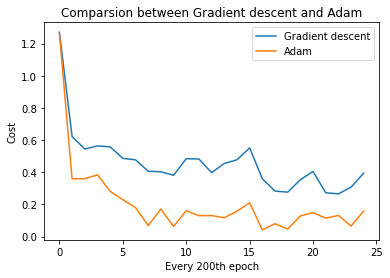

In [25]:
plt.title('Comparsion between Gradient descent and Adam')
plt.plot(tcos, label = 'Gradient descent')
plt.plot(tcos2, label = 'Adam')
plt.xlabel('Every 200th epoch')
plt.ylabel('Cost')
plt.legend()
plt.show()

# Conclusion
When same parameters are given to the model :-
1) Adam reduces the cost faster than Gradient descent.<br>
2) Accuracy of Adam is higher than Gradient descent.